# NMF modeling for player recomendations
Non negative matrix factorization(NMF) is a feature reduction technique that decomposes a matrix into two smaller matricies that can be used to cluster features from the original matrix into topics as well as calculate the distance between samples in the original matrix to allow for recomendations between the closest samples to be created. I will be using NMF to generate player recomendations to find who has the cloest stats to some of the other best progressive defenders in the MLS. 

# Objective - Take target players from EDA and use the NMF model as a recommendation system for similar players. 

### 5.1 Load model and X.

### 5.2 create W(weight) matrix through NMF to get Skill set values for each player.

### 5.2 Create dataframes and labels from NMF output for player comparisons.

### 5.3 Target player recomendations from NMF.
- Nathan Cordoso 
- Julian Gressel
- Hector Jimenez
- Kai Wagner

### 5.4 conclusion and next steps 



## 5.1 Load model and X

In [87]:
## import packages and tools
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import NMF 
from sklearn.preprocessing import Normalizer ,MaxAbsScaler
from sklearn.pipeline import make_pipeline
from utils import save_file,radar_compare, display_features, add_skill_group


In [88]:
## load nmf model 

expected_model_version = '1.0'
model_path = '../models/nmf.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
#     if model.version != expected_model_version:
#         print("Expected model version doesn't match version loaded")
#     if model.sklearn_version != sklearn_version:
#         print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

print(model)

NMF(init='nndsvda', l1_ratio=0.05, max_iter=1000, n_components=9,
    random_state=42)


In [89]:
## load data
X = pd.read_csv('../data/NMF_X.csv')
X.index= X['player_name'].values
X.drop('player_name',axis=1,inplace=True)
X.head()

,Tackle_pct_won,Nineties,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,...,pAdj_def_interceptions,pAdj_Recoveries,pAdj_Aerial_Duels_lost,lost_tackles,True_tackle_pct,pAdj_Tackle_int_blocks,avg_shrt+med_pass_pct,pct_long_balls,prog_carry+lng_comp+crosses,attacking_touches
Carles Gil,26.4,25.4,0.472441,5.275591,10.905512,48.818898,65.708661,74.3,1016.102362,390.984252,...,1.537525,10.963222,0.267396,0.401093,25.000000,2.406561,84.50,27.022169,24.960630,51.653543
Julian Gressel,28.3,29.9,0.408027,3.210702,5.551839,37.324415,57.926421,64.4,812.374582,366.153846,...,3.767145,13.905196,1.661976,1.495778,31.506849,7.589689,78.10,30.600462,17.959866,33.143813
Emanuel Reynoso,29.2,26.5,0.332075,3.433962,8.830189,42.113208,61.056604,69.0,784.867925,292.981132,...,1.658520,12.162481,1.105680,0.982827,34.502924,6.695507,78.50,23.609394,18.792453,55.056604
Albert Rusnák,28.7,33.8,0.213018,2.573964,4.289941,40.739645,48.727811,83.6,839.289941,226.863905,...,1.304421,10.591897,0.208707,0.417415,32.876712,3.287140,91.15,24.833030,15.355030,30.857988
Maximiliano Moralez,30.2,26.5,0.362264,3.132075,7.735849,46.566038,62.415094,74.6,930.830189,318.000000,...,1.526455,11.083393,0.663676,1.460088,31.372549,5.043939,83.00,25.634825,18.188679,38.716981


## 5.2 create W(weight) matrix through NMF to get Skill set values for each player.

In [90]:
# Create a MaxAbsScaler: scaler
transformer = MaxAbsScaler().fit(X)

# scale data
scaled_X= transformer.transform(X)

nmf = model

W = nmf.fit_transform(scaled_X)
H = nmf.components_
err = nmf.reconstruction_err_

print(nmf,'error :',err, '\n', ' W shape',W.shape,'H shape ',H.shape)
df_new = add_skill_group(X,W)
print(df_new['pred_topic_num'].value_counts())
            
feature_names = X.columns.values
no_top_features = 4
no_top_players = 5

# topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

NMF(init='nndsvda', l1_ratio=0.05, max_iter=1000, n_components=9,
    random_state=42) error : 16.097065673959523 
  W shape (541, 9) H shape  (9, 85)
7    99
8    98
5    87
6    79
4    70
3    48
2    40
0    18
1     2
Name: pred_topic_num, dtype: int64


In [92]:
def display_features(H,W,feature_names, X_matrix ,no_top_features, no_top_players):
    import numpy as np
    """ visualize skill get group and highest ranked players in group """
    groups = []
    topics = {}
    # iterate through topics in topic-term matrix, 'H' aka
    # H is the hidden layer which is shape (F x C) feature times topic matrix
    for topic_idx, topic in enumerate(H):
        top_players =[]
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_features - 1:-1]]))
#         group
#         groups.append[]
        
        # add features to topics dictionary for later assesment. 
        
        features = [ (feature_names[i] + " (" + str(topic[i].round(2)) + ")") 
                             for i in topic.argsort()[:-(no_top_features+3) - 1:-1]]
        fs = ''
        for i in features:
            fs = fs +str(i)
        
        
        print(type(features))
        top_player_indicies = np.argsort( W[:,topic_idx] )[::-1][0:no_top_players]
        for p_index in top_player_indicies:
            
            print(p_index," ",X_matrix.index[p_index])
            player = (p_index,X_matrix.index[p_index])
            top_players.append(player)
        topics[fs] = top_players
    final = pd.DataFrame(topics)
    
    return final 

In [192]:
topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

Topic 0:
recept_pct (9.36) avg_shrt+med_pass_pct (8.98) pct_long_balls (8.19) touches_def_box (7.97)
<class 'list'>
488   Brad Guzan
518   Maxime Crépeau
526   Zac MacMath
530   David Ochoa
428   J.T. Marcinkowski
Topic 1:
dribble_Succ (2.71) num_dribble_past (2.63) dribble_Att (2.52) dispossed (2.31)
<class 'list'>
51   Yeferson Soteldo
2   Emanuel Reynoso
136   Brian Rodríguez
6   Lucas Zelarayán
0   Carles Gil
Topic 2:
pAdj_Clearences (2.37) pAdj_Blocked_shots (2.05) touches_def_3rd (1.81) pAdj_def_interceptions (1.49)
<class 'list'>
426   Nathan Cardoso
348   Alan Franco
417   Daniel Steres
365   Rudy Camacho
422   Francisco Calvo
Topic 3:
Total_Cmp_pct (1.71) avg_shrt+med_pass_pct (1.66) recept_pct (1.44) Long_Cmp_pct (1.28)
<class 'list'>
499   Kamohelo Mokotjo
459   Ralph Priso-Mbongue
358   Emerson Hyndman
336   Kevin Molino
405   José Mauri
Topic 4:
Nineties (2.1) Total_Cmp_pct (1.69) avg_shrt+med_pass_pct (1.62) dribble_Succ_pct (1.45)
<class 'list'>
97   Darlington Nagbe
29 

In [214]:
# show top players by topic and features 

columns =['Defensive passing','Dribbling','Defensive actions','Short passing','Playing time','Tackling','Attacking play','Passing volume','Progressive passing']
multi = pd.DataFrame([columns,topics.columns]).T
topics.columns = pd.MultiIndex.from_frame(multi)
topics

,Defensive passing,Dribbling,Defensive actions,Short passing,Playing time,Tackling,Attacking play,Passing volume,Progressive passing
1,"(Defensive passing, recept_pct (9.36)avg_shrt+med_pass_pct (8.98)pct_long_balls (8.19)touches_def_box (7.97)Long_Att (7.87)Total_Prg_Dist (7.76)touches_def_3rd (7.18))","(Dribbling, dribble_Succ (2.71)num_dribble_past (2.63)dribble_Att (2.52)dispossed (2.31)carries_prog (1.95)attacking_touches (1.84)dribble_megs (1.83))","(Defensive actions, pAdj_Clearences (2.37)pAdj_Blocked_shots (2.05)touches_def_3rd (1.81)pAdj_def_interceptions (1.49)pAdj_Interceptions (1.48)Aerial_win_pct (1.39)pAdj_Tackle_int_blocks (1.39))","(Short passing, Total_Cmp_pct (1.71)avg_shrt+med_pass_pct (1.66)recept_pct (1.44)Long_Cmp_pct (1.28)dribble_Succ_pct (1.26)Dist (1.16)Short_Att (0.87))","(Playing time, Nineties (2.1)Total_Cmp_pct (1.69)avg_shrt+med_pass_pct (1.62)dribble_Succ_pct (1.45)Long_Cmp_pct (1.39)recept_pct (1.39)Short_Att (0.7))","(Tackling, pAdj_Tackles_Mid_3rd (1.1)pAdj_Total_tackles (0.97)pAdj_Tackles_Won (0.97)pAdj_Tackles_and_Ints (0.84)pAdj_Num_Dribbled_past (0.82)pAdj_Num_Dribblers_tackled (0.81)pAdj_Tackle_int_blocks (0.76))","(Attacking play, touches_att_box (1.37)SoT (1.3)npxG (1.23)xG (1.19)Sh (1.18)Offsides (1.03)Gls (1.02))","(Passing volume, touches_mid_3rd (0.87)recep_succ (0.84)Total_Cmp (0.76)Total_Att (0.76)carries (0.75)recep_targ (0.73)Total_Tot_Dist (0.72))","(Progressive passing, Crosses (1.07)touches_att_3rd (0.7)attacking_touches (0.65)Short_Att (0.54)xA (0.52)recept_pct (0.51)pAdj_Blocked_pass (0.5))"
0,"(488, Brad Guzan)","(51, Yeferson Soteldo)","(426, Nathan Cardoso)","(499, Kamohelo Mokotjo)","(97, Darlington Nagbe)","(409, Judson)","(192, Adam Buksa)","(351, Sebastian Berhalter)","(1, Julian Gressel)"
1,"(518, Maxime Crépeau)","(2, Emanuel Reynoso)","(348, Alan Franco)","(459, Ralph Priso-Mbongue)","(29, Damir Kreilach)","(462, Franco Ibarra)","(45, Valentín Castellanos)","(313, Andreu Fontàs)","(114, Maikel Chang)"
2,"(526, Zac MacMath)","(136, Brian Rodríguez)","(417, Daniel Steres)","(358, Emerson Hyndman)","(131, Brenner)","(246, Eric Remedi)","(106, Ola Kamara)","(95, Andrés Ricaurte)","(339, Mustafa Kizza)"
3,"(530, David Ochoa)","(6, Lucas Zelarayán)","(365, Rudy Camacho)","(336, Kevin Molino)","(156, Júnior Urso)","(245, Dru Yearwood)","(147, Cristian Arango)","(90, Michael Bradley)","(8, Brooks Lennon)"
4,"(428, J.T. Marcinkowski)","(0, Carles Gil)","(422, Francisco Calvo)","(405, José Mauri)","(134, Wil Trapp)","(432, Jacori Hayes)","(315, Jhonder Cádiz)","(30, Eduard Atuesta)","(49, Guðmundur Þórarinsson)"


## 5.3 create dataframes and labels for radar plot comparisons 

### 5.3.1. Create Skill get group ranking Dataframe for players from W matrix

In [210]:

columns =['Defensive passing','Dribbling','Defensive actions','Short passing','Playing time','Tackling','Attacking play','Passing volume','Progressive passing']

skill_sets.columns = columns


dfw= pd.DataFrame(W,columns=columns,index = X.index)

for col in dfw.columns.values:
    title = col +' rank'
    dfw[title] = dfw[col].rank(pct=True,na_option = 'bottom',ascending=True)
dfw['player_name'] = dfw.index
dfw[['Defensive actions','Defensive actions rank']].nlargest(3,columns='Defensive actions rank')



,Defensive actions,Defensive actions rank
Nathan Cardoso,0.355321,1.000000
Alan Franco,0.315812,0.998152
Daniel Steres,0.308983,0.996303


- New 2022 San Jose signing Francisco Calvo defensive action rank is close to the recently injured  Natahn Cardoso

### 5.3.2 Normalize W matrix and create key skill maxtrix for radar plots. 

In [211]:
# normalize values 

transformer = Normalizer().fit(W)
normed_W= transformer.transform(W)
# can add back club and salary here 
normed_df = pd.DataFrame(normed_W,index=X.index.values)


df = df = pd.read_csv('../data/final_per_90_and_pAdj.csv')
df.rename(columns={'prog_carry+lng_comp+crosses':'Progressive_play'},inplace=True)
# make df of only key features 
cdf = df[['player_name','Club',
       'Aerial_win_pct',
       'pAdj_Num_Dribblers_tackled',
       'pAdj_Num_Dribbled_past', 'pAdj_Clearences',
       'pAdj_Fouls','pAdj_Recoveries', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 'attacking_touches',
       'pct_long_balls','Progressive_play',
       ]].copy()

cdf.rename(columns={'pAdj_Clearences':'Clearences','pAdj_Fouls':'Fouls',
                   'pAdj_Recoveries':'Recoveries',
                  'pAdj_Tackle_int_blocks':'Tackle_int_blocks','pAdj_Num_Dribblers_tackled':'Num_Dribblers_tackled',
                  'pAdj_Num_Dribbled_past':'Num_Dribbled_past'},inplace=True)

#column labels 
params = list(cdf.columns)[2:]

ranks = ['Defensive passing rank', 'Dribbling rank','Defensive actions rank', 'Short passing rank',
       'Tackling rank', 'Attacking play rank', 'Passing volume rank',
       'Progressive passing rank']

## 5.4 Player recomendations from normalized W matrix

### 5.4.1 - Nathan Cordoso, San Jose Earthquakes Center Back

In [212]:
nc = normed_df.loc['Nathan Cardoso']
# use .dot to get cosine simularity 
sims = normed_df.dot(nc)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

,cosine simularity
Nathan Cardoso,1.000000
Andrés Reyes,0.956258
Judson,0.935073
Franco Ibarra,0.905343
Johan Kappelhof,0.901412


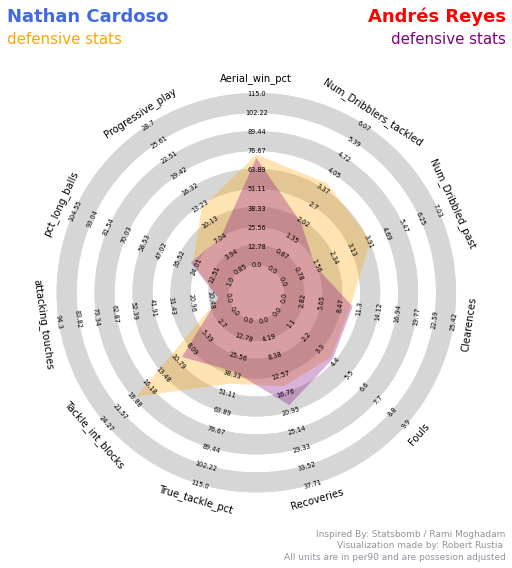

In [213]:
radar_compare('Nathan Cardoso','Andrés Reyes',params,cdf)

### Insight 
- Both players have very simular player profiles as volume defenders who are thrawting the opposings team attack directly, with both players highlighted in tackles interceptions blocks, recoveries and Aerial_win_pct. 

- Below comparison of skill groups ranks shows both players highligthed for progressive passing and short passing. 

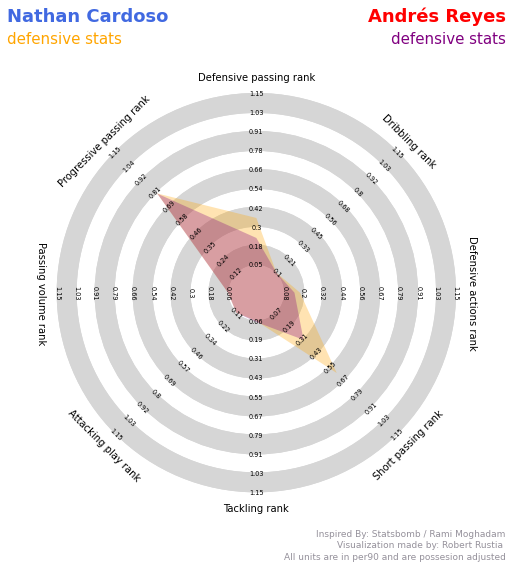

In [106]:
radar_compare('Nathan Cardoso','Andrés Reyes',ranks,dfw)

### 5.4.2 Julian Gressel, DC united, Wing back

In [107]:
JG = normed_df.loc['Julian Gressel']
# use .dot to get cosine simularity 
sims = normed_df.dot(JG)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

,cosine simularity
Julian Gressel,1.000000
Guðmundur Þórarinsson,0.965097
Brooks Lennon,0.955413
Ruan,0.955302
Brad Smith,0.948897


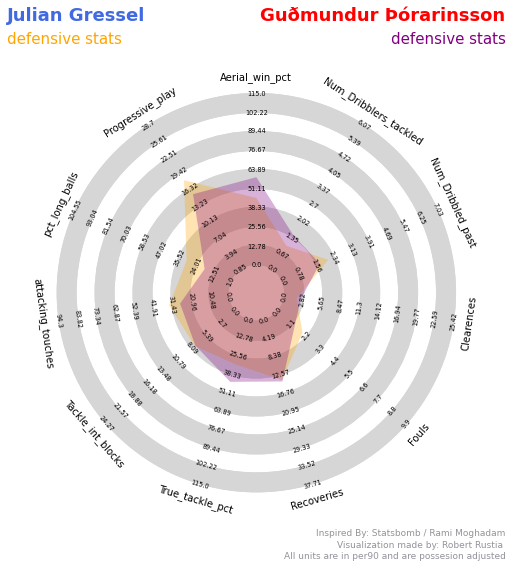

In [108]:
radar_compare('Julian Gressel','Guðmundur Þórarinsson',params,cdf)

### Insight - Guðmundur Þórarinsson who now players for AALBORG BKin the SUPERLIGAEN  after leaving NYC and their successful tital campain is closest to Julian Gressle. Both players are highligthed for their Progressive play on the ball, number of players dribbled past and recoveries. 

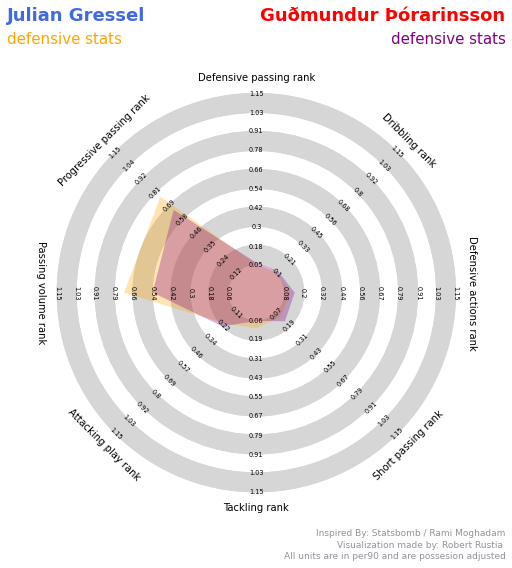

In [109]:
radar_compare('Julian Gressel','Guðmundur Þórarinsson',ranks,dfw)

### 5.4.3 Hector Jimenez , Austin FC , Defender

In [110]:
HJ = normed_df.loc['Hector Jiménez']
# use .dot to get cosine simularity 
sims = normed_df.dot(HJ)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

,cosine simularity
Hector Jiménez,1.000000
Harrison Afful,0.979864
João Moutinho,0.979183
Graham Zusi,0.977566
Cristián Gutiérrez,0.975640


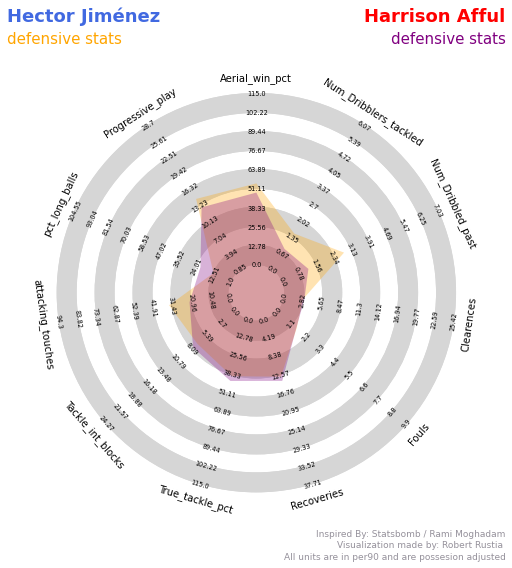

In [111]:
radar_compare('Hector Jiménez','Harrison Afful',params,cdf)

### 5.4.3 Insight 
- Harrison Afful plays as a fullback for Major League Soccer club Charlotte FC and the Ghana national team.
- Both players highlight their Progressive play in the radar above. 

- The simularities in skill sets between the two players can be seen below.

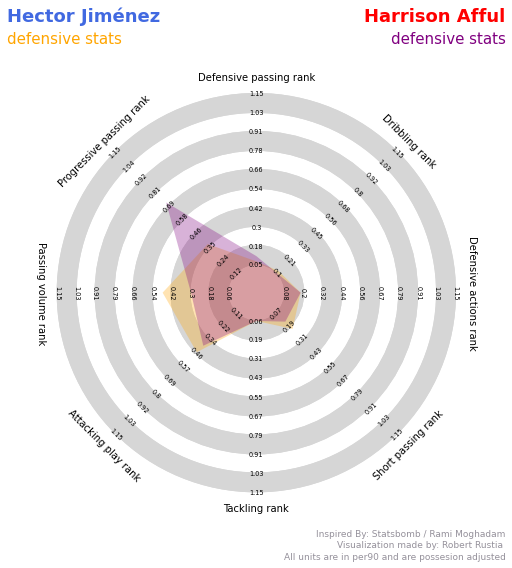

In [126]:
radar_compare('Hector Jiménez','Harrison Afful',ranks,dfw)

## 5.4.4 Walker Zimmerman, Nashville SC - Center Back

In [113]:
wz = normed_df.loc['Walker Zimmerman']
sims = normed_df.dot(wz)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

,cosine simularity
Walker Zimmerman,1.000000
Steve Birnbaum,0.967754
Tanner Beason,0.959139
Jonathan Mensah,0.953977
Bill Tuiloma,0.950487


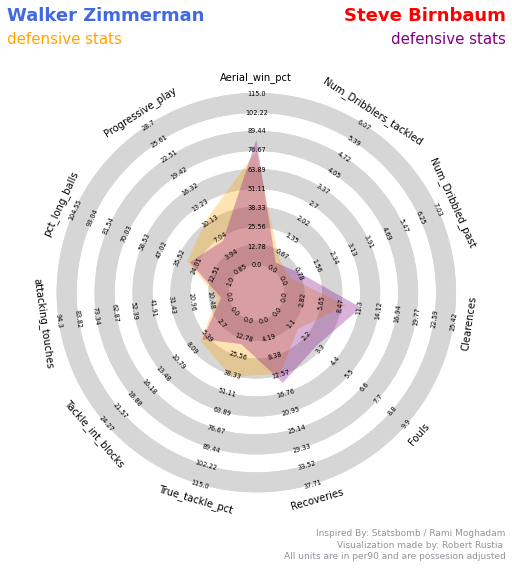

In [114]:
radar_compare('Walker Zimmerman','Steve Birnbaum',params,cdf)

### 5.4.5 Kai Wagner, Philadelphia Union - Left Back 

In [118]:
wz = normed_df.loc['Kai Wagner']
sims = normed_df.dot(wz)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

,cosine simularity
Kai Wagner,1.000000
Anton Tinnerholm,0.989979
Romain Métanire,0.986548
Alistair Johnston,0.984361
Aaron Herrera,0.984346


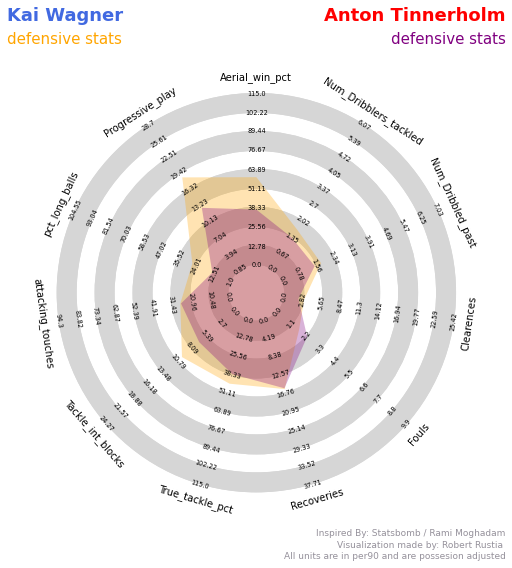

In [119]:
radar_compare('Kai Wagner','Anton Tinnerholm',params,cdf)

### 5.4.6 Graham Zusi, Sporting Kansas City, left wing back

In [124]:
wz = normed_df.loc['Graham Zusi']
sims = normed_df.dot(wz)
sims = pd.DataFrame(sims,columns=['cosine simularity'])

# players with closest angle to Nathan Cardoso
sims.sort_values(by = 'cosine simularity',ascending=False)[:5]

,cosine simularity
Graham Zusi,1.000000
Harrison Afful,0.990891
Hector Jiménez,0.977566
Luís Martins,0.974613
João Moutinho,0.970647


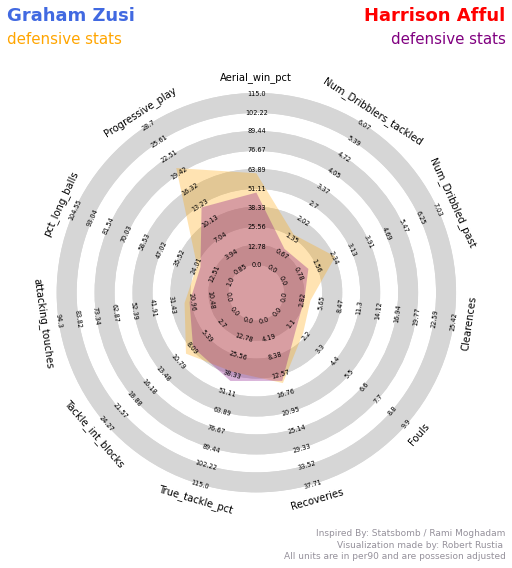

In [125]:
radar_compare('Graham Zusi','Harrison Afful',params,cdf)

#### 5.4.6 Insight 
- Grahm Zusi and Hector Jiménez both are very close in cosine simularity to Harrison Afful the Charlotte FC fullback.
- clear simularities in Zusi, who has convereted from a midfielder into a deeper lying playmaker and Affuls stats, with almost idential recovieries and attacking touches.
- both players are highlighted for their progressive play making them both suitable for teams looking to play out from the back. 

## 5.5 Identified Player Heatmap Comparison

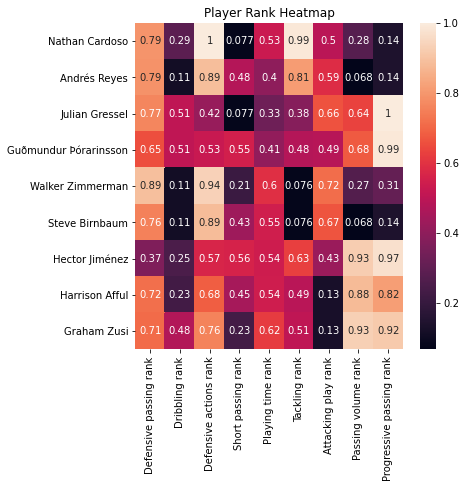

In [218]:



# USE HEAT MAP TO SHOW PLAYER COMPARISONS AT END 
comparisons = dfw.loc[['Nathan Cardoso','Andrés Reyes','Julian Gressel',
                       'Guðmundur Þórarinsson','Walker Zimmerman','Steve Birnbaum',
                      'Hector Jiménez','Harrison Afful','Graham Zusi']]
comparisons.drop('player_name',axis=1,inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
sns.heatmap(comparisons.iloc[:,-9:],annot=True)
plt.title('Player Rank Heatmap')
plt.show()

In [215]:
topics

,Defensive passing,Dribbling,Defensive actions,Short passing,Playing time,Tackling,Attacking play,Passing volume,Progressive passing
1,"(Defensive passing, recept_pct (9.36)avg_shrt+med_pass_pct (8.98)pct_long_balls (8.19)touches_def_box (7.97)Long_Att (7.87)Total_Prg_Dist (7.76)touches_def_3rd (7.18))","(Dribbling, dribble_Succ (2.71)num_dribble_past (2.63)dribble_Att (2.52)dispossed (2.31)carries_prog (1.95)attacking_touches (1.84)dribble_megs (1.83))","(Defensive actions, pAdj_Clearences (2.37)pAdj_Blocked_shots (2.05)touches_def_3rd (1.81)pAdj_def_interceptions (1.49)pAdj_Interceptions (1.48)Aerial_win_pct (1.39)pAdj_Tackle_int_blocks (1.39))","(Short passing, Total_Cmp_pct (1.71)avg_shrt+med_pass_pct (1.66)recept_pct (1.44)Long_Cmp_pct (1.28)dribble_Succ_pct (1.26)Dist (1.16)Short_Att (0.87))","(Playing time, Nineties (2.1)Total_Cmp_pct (1.69)avg_shrt+med_pass_pct (1.62)dribble_Succ_pct (1.45)Long_Cmp_pct (1.39)recept_pct (1.39)Short_Att (0.7))","(Tackling, pAdj_Tackles_Mid_3rd (1.1)pAdj_Total_tackles (0.97)pAdj_Tackles_Won (0.97)pAdj_Tackles_and_Ints (0.84)pAdj_Num_Dribbled_past (0.82)pAdj_Num_Dribblers_tackled (0.81)pAdj_Tackle_int_blocks (0.76))","(Attacking play, touches_att_box (1.37)SoT (1.3)npxG (1.23)xG (1.19)Sh (1.18)Offsides (1.03)Gls (1.02))","(Passing volume, touches_mid_3rd (0.87)recep_succ (0.84)Total_Cmp (0.76)Total_Att (0.76)carries (0.75)recep_targ (0.73)Total_Tot_Dist (0.72))","(Progressive passing, Crosses (1.07)touches_att_3rd (0.7)attacking_touches (0.65)Short_Att (0.54)xA (0.52)recept_pct (0.51)pAdj_Blocked_pass (0.5))"
0,"(488, Brad Guzan)","(51, Yeferson Soteldo)","(426, Nathan Cardoso)","(499, Kamohelo Mokotjo)","(97, Darlington Nagbe)","(409, Judson)","(192, Adam Buksa)","(351, Sebastian Berhalter)","(1, Julian Gressel)"
1,"(518, Maxime Crépeau)","(2, Emanuel Reynoso)","(348, Alan Franco)","(459, Ralph Priso-Mbongue)","(29, Damir Kreilach)","(462, Franco Ibarra)","(45, Valentín Castellanos)","(313, Andreu Fontàs)","(114, Maikel Chang)"
2,"(526, Zac MacMath)","(136, Brian Rodríguez)","(417, Daniel Steres)","(358, Emerson Hyndman)","(131, Brenner)","(246, Eric Remedi)","(106, Ola Kamara)","(95, Andrés Ricaurte)","(339, Mustafa Kizza)"
3,"(530, David Ochoa)","(6, Lucas Zelarayán)","(365, Rudy Camacho)","(336, Kevin Molino)","(156, Júnior Urso)","(245, Dru Yearwood)","(147, Cristian Arango)","(90, Michael Bradley)","(8, Brooks Lennon)"
4,"(428, J.T. Marcinkowski)","(0, Carles Gil)","(422, Francisco Calvo)","(405, José Mauri)","(134, Wil Trapp)","(432, Jacori Hayes)","(315, Jhonder Cádiz)","(30, Eduard Atuesta)","(49, Guðmundur Þórarinsson)"


### 5.5 Insight  
- Heat map allows all defensive players Identified through NMF recomendation can be compared by their NMF feature ranks.

- Many players identified rank in the 90th percentile and above in progressive passing feature rank which included features such as Crosses, touches_att_3rd, attacking_touches, xA. 

- all but two players are between the 70th and  80th percentile in defensive passing feature rank which included  features such as recept_pct, avg_shrt+med_pass_pct, pct_long_balls,touches_def_box, Long_Att,touches_def_3rd. The top percentile players are all Goal keepers so field players were father down the ranking.

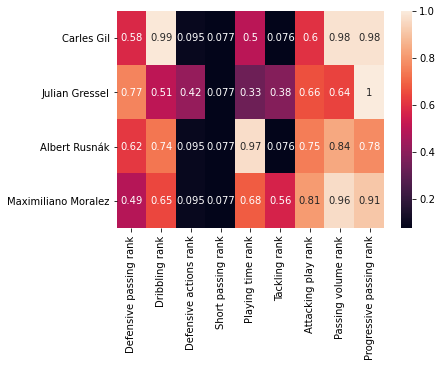

In [220]:
# Attacking players can also easily be compared with heatmap of skillset  
comparisons = dfw.loc[['Carles Gil','Julian Gressel','Albert Rusnák','Maximiliano Moralez']]
comparisons.drop('player_name',axis=1,inplace=True)
sns.heatmap(comparisons.iloc[:,-9:],annot=True)
plt.show()